In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import seaborn as sns
plt.style.use('seaborn-white')
sns.set_context('talk')
sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})

In [2]:
log_directory = '../../../data/raw/logs/'
ucx_directory = '../../../data/raw/ucx_tests/results/'

# Load UCX data for comparison

In [3]:
get_df = pd.read_csv(ucx_directory + "get_client.csv", skiprows=1)
put_lat_df = pd.read_csv(ucx_directory + "put_lat_client.csv", skiprows=1)
stream_lat_df = pd.read_csv(ucx_directory +  "stream_lat_client.csv", skiprows=1)

In [4]:
def testname_to_cols(dataframe):
    df = dataframe.iloc[:, 0].str.extract(r'([a-zA-Z]+)_(?:[a-zA-Z]+_)?(\d+)')
    dataframe["operation"] = df[0]
    dataframe["message_size"] = df[1].astype("int64")

In [5]:
testname_to_cols(get_df)
testname_to_cols(put_lat_df)
testname_to_cols(stream_lat_df)

In [6]:
ucx_df = pd.DataFrame()
for df in [get_df, put_lat_df, stream_lat_df]:
    ucx_df = pd.concat([ucx_df, df[["operation", "message_size", "avg_bw", "avg_mr", "avg_lat"]]])
# Clean up calculation
ucx_df["avg_bw"] = ucx_df["avg_mr"] * ucx_df["message_size"] / (1000. * 1000)
ucx_df.head()

,operation,message_size,avg_bw,avg_mr,avg_lat
0,GET,2,1.107626,553813,1.806
1,GET,4,2.337472,584368,1.711
2,GET,8,4.451168,556396,1.797
3,GET,16,9.306928,581683,1.719
4,GET,32,17.717056,553658,1.806


# Ghostwriter/Kafka Throughput

In [7]:
def get_log_files(dir_path, pattern):
    result = []
    for filename in os.listdir(dir_path):
        res = re.search(pattern, filename)
        if res:
            data_size = res.group(1)
            segment_count = res.group(2)
            rate_limit = res.group(3)
            if data_size:
                result.append((data_size, segment_count, rate_limit, dir_path + "/" + filename))
    return result

In [8]:
def get_kafka_files(dir_path, pattern):
    result = []
    for filename in os.listdir(dir_path):
        res = re.search(pattern, filename)
        if res:
            data_size = res.group(1)
            rate_limit = res.group(2)
            if data_size:
                result.append((data_size, rate_limit, dir_path + "/" + filename))
    return result

In [9]:
def get_consumer_files(dir_path, pattern):
    result = []
    for filename in os.listdir(dir_path):
        res = re.search(pattern, filename)
        if res:
            data_size = res.group(1)
            if data_size:
                result.append((data_size, dir_path + "/" + filename))
    return result

# Maximum Producer Throughput

In [10]:
def get_kafka_producer_throughput_files():
    return get_kafka_files(log_directory + "20200602/throughput", "kafka_producer_(\d+)_(\d+)_throughput.csv")

In [11]:
def get_exclusive_producer_throughput_files():
    return get_log_files(log_directory + "20200719/throughput/exclusive", "rembrandt_producer_(\d+)_(\d+)_(\d+)_throughput.csv")
def get_exclusive_opt_producer_throughput_files():
    return get_log_files(log_directory + "20200719/throughput/exclusive_opt", "rembrandt_producer_(\d+)_(\d+)_(\d+)_throughput.csv")
def get_concurrent_producer_throughput_files():
    return get_log_files(log_directory + "20200724/throughput/concurrent", "rembrandt_producer_(\d+)_(\d+)_(\d+)_throughput.csv")
def get_concurrent_opt_producer_throughput_files():
    return get_log_files(log_directory + "20200724/throughput/concurrent_opt/10", "rembrandt_producer_(\d+)_(\d+)_(\d+)_throughput.csv")

In [12]:
def get_kafka_consumer_throughput_files():
    return get_kafka_files(log_directory + "20200602/throughput", "kafka_consumer_(\d+)_(\d+)_throughput.csv")

In [13]:
def get_exclusive_consumer_throughput_files():
    return get_consumer_files(log_directory + "20200719/throughput/exclusive", "rembrandt_consumer_(\d+)_throughput.csv")
def get_exclusive_opt_consumer_throughput_files():
    return get_consumer_files(log_directory + "20200719/throughput/exclusive_opt", "rembrandt_consumer_(\d+)_throughput.csv")
def get_concurrent_consumer_throughput_files():
    return get_consumer_files(log_directory + "20200724/throughput/concurrent", "rembrandt_consumer_(\d+)_throughput.csv")
def get_concurrent_opt_consumer_throughput_files():
    return get_consumer_files(log_directory + "20200724/throughput/concurrent_opt/10", "rembrandt_consumer_(\d+)_throughput.csv")

In [14]:
def create_rembrandt_dataframe(log_files, skiprows=0):
    joined_df = pd.DataFrame()
    for data_size, segment_count, rate_limit, filename in log_files:
        df  = pd.read_csv(filename, sep='\t', skiprows=skiprows)
        df.reset_index(inplace=True)
        df["Message Size"] = int(data_size)
        df["# of Segments"] = int(segment_count)
        df["Rate Limit in MB/s"] = int(rate_limit) // (1000 * 1000)
        joined_df = pd.concat([joined_df, df])
    return joined_df

In [15]:
def create_kafka_producer_dataframe(log_files, skiprows=0):
    joined_df = pd.DataFrame()
    for data_size, rate_limit, filename in log_files:
        df  = pd.read_csv(filename, sep='\t', skiprows=skiprows)
        df.reset_index(inplace=True)
        df["Message Size"] = int(data_size)
        df["Rate Limit in MB/s"] = int(rate_limit) // (1000 * 1000)
        joined_df = pd.concat([joined_df, df])
    return joined_df

In [16]:
kafka_producer_log_files = get_kafka_producer_throughput_files()
kafka_producer_df = create_kafka_producer_dataframe(kafka_producer_log_files)
kafka_producer_df.head()

,index,Number of Messages,Throughput in MB/s,Message Size,Rate Limit in MB/s
0,0,3243,212.533,65536,1000
1,1,3315,217.252,65536,1000
2,2,3223,211.223,65536,1000
3,3,2829,185.401,65536,1000
4,4,2859,187.367,65536,1000


In [17]:
exclusive_producer_log_files = get_exclusive_producer_throughput_files()
exclusive_producer_df = create_rembrandt_dataframe(exclusive_producer_log_files)
exclusive_producer_df.head()

,index,Number of Messages,Throughput in MB/s,Message Size,# of Segments,Rate Limit in MB/s
0,0,58175,953.139,16384,1,15000
1,1,58053,951.140,16384,1,15000
2,2,58934,965.575,16384,1,15000
3,3,58866,964.461,16384,1,15000
4,4,57937,949.240,16384,1,15000


In [18]:
exclusive_opt_producer_log_files = get_exclusive_opt_producer_throughput_files()
exclusive_opt_producer_df = create_rembrandt_dataframe(exclusive_opt_producer_log_files)
exclusive_opt_producer_df.head()

,index,Number of Messages,Throughput in MB/s,Message Size,# of Segments,Rate Limit in MB/s
0,0,70274,1151.369,16384,1,15000
1,1,70968,1162.740,16384,1,15000
2,2,70657,1157.644,16384,1,15000
3,3,70343,1152.500,16384,1,15000
4,4,70237,1150.763,16384,1,15000


In [19]:
concurrent_producer_log_files = get_concurrent_producer_throughput_files()
concurrent_producer_df = create_rembrandt_dataframe(concurrent_producer_log_files)
concurrent_producer_df.head()

,index,Number of Messages,Throughput in MB/s,Message Size,# of Segments,Rate Limit in MB/s
0,0,50572,828.572,16384,90,15000
1,1,51046,836.338,16384,90,15000
2,2,51038,836.207,16384,90,15000
3,3,51045,836.321,16384,90,15000
4,4,50221,822.821,16384,90,15000


In [20]:
concurrent_opt_producer_log_files = get_concurrent_opt_producer_throughput_files()
concurrent_opt_producer_df = create_rembrandt_dataframe(concurrent_opt_producer_log_files)
concurrent_opt_producer_df.head()

,index,Number of Messages,Throughput in MB/s,Message Size,# of Segments,Rate Limit in MB/s
0,0,70166,1149.600,16384,90,15000
1,1,70906,1161.724,16384,90,15000
2,2,71095,1164.820,16384,90,15000
3,3,68983,1130.217,16384,90,15000
4,4,68926,1129.284,16384,90,15000


In [21]:
def plot_histogram(dataframe):
#     fig_dims = (18, 12)
    fig, ax = plt.subplots()
    sns.set_context('poster')
    sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})
    sns.despine(left=True)
    g = sns.lineplot(x="Message Size in Bytes", y="Throughput in MB/s", data=dataframe, ax=ax,ci="sd")
    g.set_xlabel("Message Size")
    ax.set_xscale('log')
    g.set_xticks([8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576, 2097152, 4194304, 8388608])
    g.set_xticklabels(['8K','16K','32K','64K','128K','256K','512K','1M', '2M', '4M', '8M'])
    plt.xticks(fontsize=20, rotation=45)
    plt.yticks(fontsize=20)

In [23]:
concurrent_producer_df.groupby("Message Size").mean()

,index,Number of Messages,Throughput in MB/s,# of Segments,Rate Limit in MB/s
Message Size,,,,,
8192,96.0,54058.937824,442.850824,90.0,15000.0
16384,51.5,50208.000000,822.607913,90.0,15000.0
32768,30.0,42704.721311,1399.348295,90.0,15000.0
65536,18.0,34520.351351,2262.325730,90.0,15000.0
131072,15.0,20833.000000,2730.622935,90.0,15000.0
262144,9.0,16639.473684,4361.938211,90.0,15000.0
524288,7.0,10716.000000,5618.270200,90.0,15000.0
1048576,6.0,6013.846154,6305.974769,90.0,15000.0
2097152,5.5,3193.750000,6697.779167,90.0,15000.0


In [24]:
producer_dfs = {"Kafka": kafka_producer_df, "Excl.": exclusive_producer_df, "Excl. Opt.": exclusive_opt_producer_df, "Conc.": concurrent_producer_df, "Conc. Opt.": concurrent_opt_producer_df}

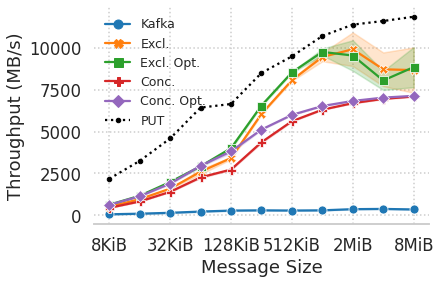

In [25]:
for label, dataframe in producer_dfs.items():
    dataframe["Broker"] = label
df = pd.concat(producer_dfs.values())
fig, ax = plt.subplots()
sns.despine(left=True)
baseline = ucx_df[ucx_df["operation"] == "PUT"]
baseline = baseline[baseline["message_size"] >= 8192]
g = sns.lineplot(x="Message Size", y="Throughput in MB/s", hue="Broker", style="Broker", data=df, ax=ax,ci="sd", markers=True, dashes=False)
plt.plot(baseline["message_size"], baseline["avg_bw"], color='black', ls=':', marker=".",label="PUT")
g.set_ylabel("Throughput (MB/s)")
ax.set_xscale('log')
g.set_xticks([8192, 32768, 131072, 524288, 2097152, 8388608])
g.set_xticklabels(['8KiB', '32KiB','128KiB','512KiB', '2MiB', '8MiB'])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:],fontsize='x-small')
fig.savefig("ghostwriter_producer_throughput.pdf", bbox_inches="tight", dpi=600)

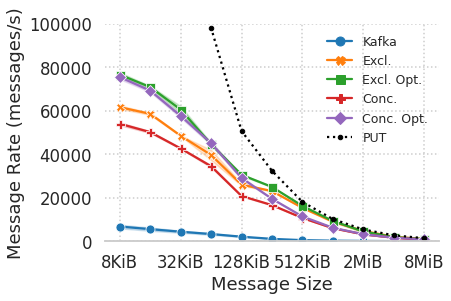

In [26]:
for label, dataframe in producer_dfs.items():
    dataframe["Broker"] = label
df = pd.concat(producer_dfs.values())
fig, ax = plt.subplots()
sns.despine(left=True)
baseline = ucx_df[ucx_df["operation"] == "PUT"]
baseline = baseline[baseline["message_size"] >= 8192]
g = sns.lineplot(x="Message Size", y="Number of Messages", hue="Broker", style="Broker", data=df, ax=ax,ci="sd", markers=True, dashes=False)
plt.plot(baseline["message_size"], baseline["avg_mr"], color='black', ls=':', marker=".",label="PUT")
g.set_ylabel("Message Rate (messages/s)")
ax.set_xscale('log')
g.set_xticks([8192, 32768, 131072, 524288, 2097152, 8388608])
g.set_xticklabels(['8KiB', '32KiB','128KiB','512KiB', '2MiB', '8MiB'])
g.set(ylim=(0, 100000))
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:],fontsize='x-small')
fig.savefig("ghostwriter_producer_message_rate.pdf", bbox_inches="tight", dpi=600)

In [27]:
def create_kafka_consumer_dataframe(log_files, skiprows=0):
    joined_df = pd.DataFrame()
    for data_size, rate_limit, filename in log_files:
        df  = pd.read_csv(filename, sep='\t', skiprows=skiprows)
        df.reset_index(inplace=True)
        df["Message Size"] = int(data_size)
        joined_df = pd.concat([joined_df, df])
    return joined_df

In [28]:
def create_rembrandt_consumer_dataframe(log_files, skiprows=0):
    joined_df = pd.DataFrame()
    for data_size, filename in log_files:
        df  = pd.read_csv(filename, sep='\t', skiprows=skiprows)
        df.reset_index(inplace=True)
        df["Message Size"] = int(data_size)
        joined_df = pd.concat([joined_df, df])
    return joined_df

In [29]:
kafka_consumer_log_files = get_kafka_consumer_throughput_files()
kafka_consumer_df = create_kafka_consumer_dataframe(kafka_consumer_log_files)
kafka_consumer_df.head()

,index,Number of Messages,Throughput in MB/s,Message Size
0,0,2320,38.011,16384
1,1,2431,39.830,16384
2,2,3511,57.524,16384
3,3,3403,55.755,16384
4,4,3436,56.295,16384


In [30]:
exclusive_consumer_log_files = get_exclusive_consumer_throughput_files()
exclusive_consumer_df = create_rembrandt_consumer_dataframe(exclusive_consumer_log_files)
exclusive_consumer_df.head()

,index,Number of Messages,Throughput in MB/s,Message Size
0,0,2767,11605.639,4194304
1,1,2768,11609.833,4194304
2,2,2767,11605.639,4194304
3,3,2768,11609.833,4194304
4,4,2766,11601.445,4194304


In [31]:
exclusive_opt_consumer_log_files = get_exclusive_opt_consumer_throughput_files()
exclusive_opt_consumer_df = create_rembrandt_consumer_dataframe(exclusive_opt_consumer_log_files)
exclusive_opt_consumer_df.head()

,index,Number of Messages,Throughput in MB/s,Message Size
0,0,2796,11727.274,4194304
1,1,2796,11727.274,4194304
2,2,2796,11727.274,4194304
3,3,2796,11727.274,4194304
4,4,2796,11727.274,4194304


In [32]:
concurrent_consumer_log_files = get_concurrent_consumer_throughput_files()
concurrent_consumer_df = create_rembrandt_consumer_dataframe(concurrent_consumer_log_files)
concurrent_consumer_df.head()

,index,Number of Messages,Throughput in MB/s,Message Size
0,0,2648,11106.517,4194304
1,1,2648,11106.517,4194304
2,2,2647,11102.323,4194304
3,3,2648,11106.517,4194304
4,4,2647,11102.323,4194304


In [33]:
concurrent_opt_consumer_log_files = get_concurrent_opt_consumer_throughput_files()
concurrent_opt_consumer_df = create_rembrandt_consumer_dataframe(concurrent_opt_consumer_log_files)
concurrent_opt_consumer_df.head()

,index,Number of Messages,Throughput in MB/s,Message Size
0,0,2676,11223.958,4194304
1,1,2676,11223.958,4194304
2,2,2675,11219.763,4194304
3,3,2676,11223.958,4194304
4,4,2675,11219.763,4194304


In [34]:
consumer_dfs = {"Kafka": kafka_consumer_df, "Excl.": exclusive_consumer_df, "Excl. Opt.": exclusive_opt_consumer_df, "Conc.": concurrent_consumer_df, "Conc. Opt.": concurrent_opt_consumer_df}

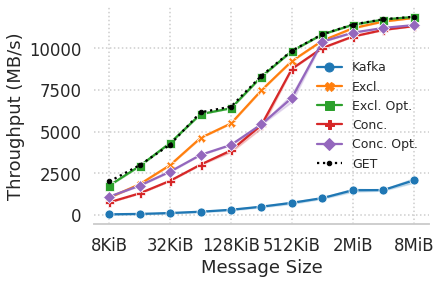

In [35]:
for label, dataframe in consumer_dfs.items():
    dataframe["Broker"] = label
df = pd.concat(consumer_dfs.values())
fig, ax = plt.subplots()
sns.despine(left=True)
baseline = ucx_df[ucx_df["operation"] == "GET"]
baseline = baseline[baseline["message_size"] >= 8192]
g = sns.lineplot(x="Message Size", y="Throughput in MB/s", hue="Broker", style="Broker", data=df, ax=ax,ci="sd", markers=True, dashes=False)
plt.plot(baseline["message_size"], baseline["avg_bw"], color='black', ls=':', marker=".",label="GET")
g.set_ylabel("Throughput (MB/s)")
ax.set_xscale('log')
g.set_xticks([8192, 32768, 131072, 524288, 2097152, 8388608])
g.set_xticklabels(['8KiB', '32KiB','128KiB','512KiB', '2MiB', '8MiB'])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:],fontsize='x-small')
fig.savefig("ghostwriter_consumer_throughput.pdf", bbox_inches="tight", dpi=600)

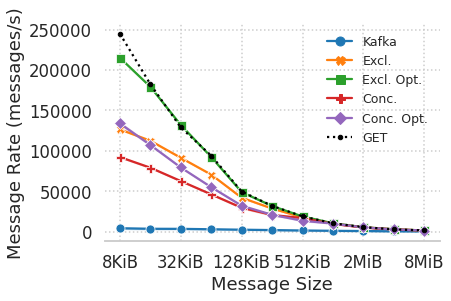

In [36]:
for label, dataframe in consumer_dfs.items():
    dataframe["Broker"] = label
df = pd.concat(consumer_dfs.values())
fig, ax = plt.subplots()
sns.despine(left=True)
baseline = ucx_df[ucx_df["operation"] == "GET"]
baseline = baseline[baseline["message_size"] >= 8192]
g = sns.lineplot(x="Message Size", y="Number of Messages", hue="Broker", style="Broker", data=df, ax=ax,ci="sd", markers=True, dashes=False)
plt.plot(baseline["message_size"], baseline["avg_mr"], color='black', ls=':', marker=".",label="GET")
g.set_ylabel("Message Rate (messages/s)")
ax.set_xscale('log')
g.set_xticks([8192, 32768, 131072, 524288, 2097152, 8388608])
g.set_xticklabels(['8KiB', '32KiB','128KiB','512KiB', '2MiB', '8MiB'])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:],fontsize='x-small')
fig.savefig("ghostwriter_consumer_message_rate.pdf", bbox_inches="tight", dpi=600)